In [1]:
import torch
import torch.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {w: i+1 for i, w in enumerate(chars)}
stoi['.'] = 0
itos = {i: w for w, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [57]:
def build_dataset(words, block_size):
    X = []
    Y = []
    for word in words:
        ctx = [0] * block_size
        for c in word + '.':
            X.append(ctx)
            Y.append(stoi[c])
            #print(''.join(itos[x] for x in ctx), '--->',c)
            ctx = ctx[1:] + [stoi[c]]

    X = torch.tensor(X, device='mps')
    Y = torch.tensor(Y, device='mps')
    return X, Y

import random
random.shuffle(words)
n1 = int(len(words) * .8)
n2 = int(len(words) * .9)

block_size = 3
Xtrain, Ytrain = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xtest, Ytest = build_dataset(words[n2:], block_size)

In [58]:
Xtrain.shape, Ytrain.shape

(torch.Size([182401, 3]), torch.Size([182401]))

# Model ideas

In [86]:
emb_dim = 2
C = torch.randn((len(stoi), emb_dim))

In [87]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [88]:
W1 = torch.randn((emb_dim * block_size, 100))
b1 = torch.randn(100)

In [89]:
h = torch.tanh(emb.view((-1, emb_dim * block_size)) @ W1 + b1)

In [90]:
h.shape

torch.Size([228146, 100])

In [91]:
W2 = torch.randn((100, len(stoi)))
b2 = torch.randn(len(stoi))

In [92]:
logits = h @ W2 + b2

In [93]:
logits.shape

torch.Size([228146, 27])

In [94]:
counts = logits.exp()

In [95]:
probs = counts / counts.sum(1, keepdim=True)

In [96]:
probs.shape

torch.Size([228146, 27])

In [97]:
probs[0].sum()

tensor(1.0000)

In [98]:
loss = -torch.log(probs[:, Y]).mean()
loss

: 

# Network Setup

In [59]:
g = torch.Generator().manual_seed(2147483647)
emb_dim = 10
mlp_dim = 200
C = torch.randn((len(stoi), emb_dim), generator=g, device='mps')
W1 = torch.randn((emb_dim * block_size, mlp_dim), generator=g, device='mps')
b1 = torch.randn(mlp_dim, generator=g, device='mps')
W2 = torch.randn((mlp_dim, len(stoi)), generator=g, device='mps')
b2 = torch.randn(len(stoi), generator=g, device='mps')
params = [C, W1, b1, W2, b2]

In [60]:
print("Model Params:", sum(p.nelement() for p in params))

Model Params: 11897


In [61]:
for p in params:
    p.requires_grad = True

# Learning Rate

In [62]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

lri = []
lossi = []
stepi = []

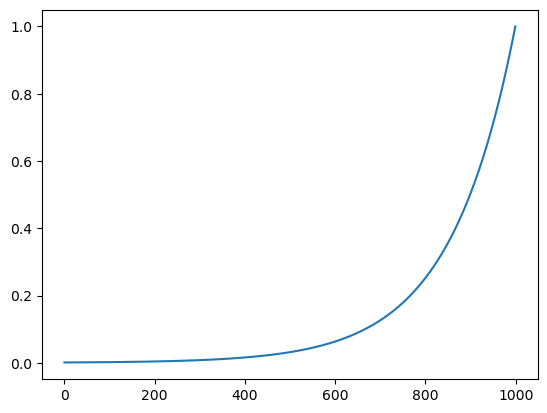

In [63]:
plt.plot(range(1000), lrs)

# Training

In [70]:
mps_device = torch.device('mps')
batch_size = 64

for i in range(40000):
    ix = torch.randint(0, Xtrain.shape[0], (batch_size,))
    emb = C[Xtrain[ix]]
    h = torch.tanh(emb.view((-1, emb_dim * block_size)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = torch.nn.functional.cross_entropy(logits, Ytrain[ix])
    for p in params:
        p.grad = None
    loss.backward()

    #learning_rate = lrs[i]
    learning_rate = 0.01
    for p in params:
        p.data += -learning_rate * p.grad

    stepi.append(i)
    #lri.append(lre[i])
    lossi.append(loss.item())

print(loss)

tensor(1.9725, device='mps:0', grad_fn=<NllLossBackward0>)


# Validation

In [71]:
emb = C[Xdev]
h = torch.tanh(emb.view((-1, emb_dim * block_size)) @ W1 + b1)
logits = h @ W2 + b2
loss = torch.nn.functional.cross_entropy(logits, Ydev)
loss

tensor(2.1630, device='mps:0', grad_fn=<NllLossBackward0>)

In [47]:
stepi = stepi[:-2]


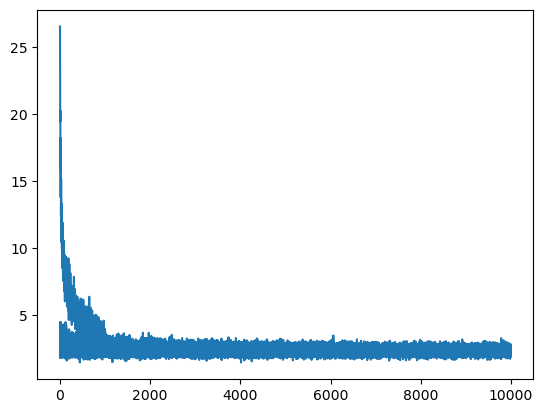

In [48]:
plt.plot(stepi, lossi)

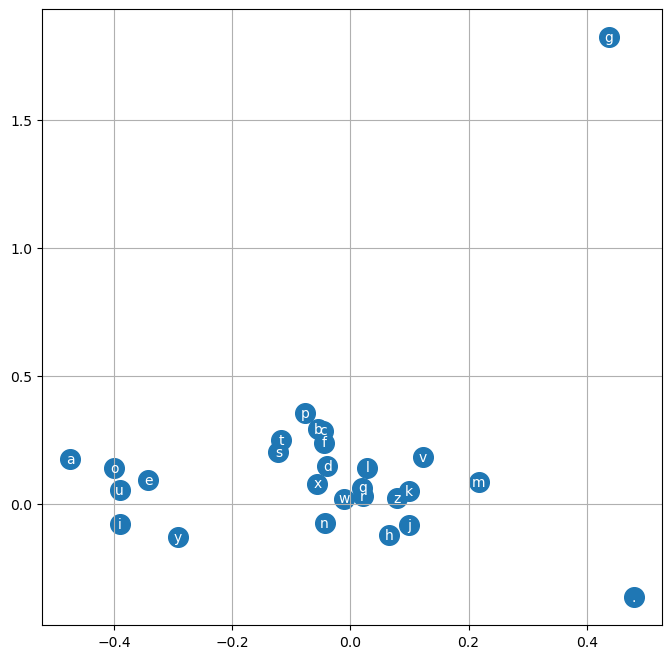

In [135]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha=
             'center', va='center', color='white')
plt.grid('minor')